# Rough Draft Workbook for Zillow Project

In [1]:
# Basics
import numpy as np
import pandas as pd
import os
import scipy.stats as stats
from pydataset import data
from scipy import math


# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Models and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Custom
import env
import wrangle_prep as wp

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# set up my variables
df = wp.wrangle_zillow()
df.head(3)

Saving to .csv


,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror
0,14297519,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,1286.0,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595
1,17052889,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,2061.0,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619
2,14186244,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,1286.0,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383


In [3]:
# since were looking at logerror, lets feature engineer around that first
# first with the addition of an absolute value column
df['abs_logerror'] = abs(df.logerror)

# second property age, which helps with visualization
df.yearbuilt = df.yearbuilt.astype(int)
df['age'] = 2017 - df.yearbuilt
df.yearbuilt = df.yearbuilt.astype(object)

df.head(4)

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
0,14297519,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,1286.0,96978.0,0.0,1998,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,0.025595,19
1,17052889,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,2061.0,97099.0,5.0,1967,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,0.055619,50
2,14186244,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,1286.0,97078.0,6.0,1962,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,0.005383,55
3,12177905,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,3101.0,96330.0,0.0,1970,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,0.103410,47


In [4]:
# Verify
df.shape

(67977, 23)

In [5]:
# train, validate, test split
train, validate, test = wp.split_data(df)

train <> (38066, 23)
validate <> (16315, 23)
test <> (13596, 23)


In [6]:
# Data for modeling
x_train = train.drop(columns=['logerror'])
y_train = train.logerror

x_validate = validate.drop(columns=['logerror'])
y_validate = validate.logerror

x_test = test.drop(columns=['logerror'])
y_test = test.logerror

# Scaling
x_train_scaled, x_validate_scaled, x_test_scaled = wp.scale_data(x_train, x_validate, x_test)

train_scaled <> (38066, 22)
validate_scaled <> (16315, 22)
test_scaled <> (13596, 22)


# Initial Exploration

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67977 entries, 0 to 77573
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      67977 non-null  int64  
 1   bathroomcnt                   67977 non-null  float64
 2   bedroomcnt                    67977 non-null  float64
 3   buildingqualitytypeid         67977 non-null  float64
 4   calculatedfinishedsquarefeet  67977 non-null  float64
 5   fips                          67977 non-null  float64
 6   latitude                      67977 non-null  float64
 7   longitude                     67977 non-null  float64
 8   lotsizesquarefeet             67977 non-null  float64
 9   rawcensustractandblock        67977 non-null  float64
 10  regionidcity                  67977 non-null  float64
 11  regionidcounty                67977 non-null  float64
 12  regionidzip                   67977 non-null  float64
 13  r

In [8]:
df.describe()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
count,6.797700e+04,67977.000000,67977.000000,67977.000000,67977.000000,67977.000000,6.797700e+04,6.797700e+04,6.797700e+04,6.797700e+04,67977.000000,67977.000000,67977.000000,67977.000000,6.797700e+04,6.797700e+04,67977.0,6.797700e+04,67977.000000,67977.000000,67977.000000,67977.000000
mean,1.301859e+07,2.202208,2.979361,6.314400,1675.335643,6049.441002,3.400452e+07,-1.181922e+08,2.785835e+04,6.049738e+07,33629.109905,2497.538903,96599.725907,1.602057,1.633991e+05,4.128805e+05,2016.0,2.494814e+05,5062.504630,0.016567,0.066315,48.171514
std,2.138710e+06,0.841592,0.980254,1.316425,764.510956,20.981742,2.689044e+05,3.618898e+05,1.204185e+05,2.082548e+05,46958.881196,814.755364,3314.077112,2.907933,1.267090e+05,3.029315e+05,0.0,2.225690e+05,3494.811018,0.164081,0.150995,22.792962
min,1.071186e+07,0.000000,0.000000,1.000000,128.000000,6037.000000,3.333953e+07,-1.194753e+08,2.360000e+02,6.037101e+07,3491.000000,1286.000000,95982.000000,0.000000,4.400000e+01,3.254000e+03,2016.0,1.610000e+02,19.920000,-4.655420,0.000002,1.000000
25%,1.153706e+07,2.000000,2.000000,6.000000,1156.000000,6037.000000,3.380559e+07,-1.184068e+08,6.000000e+03,6.037400e+07,12447.000000,1286.000000,96212.000000,0.000000,8.177700e+04,1.986290e+05,2016.0,7.919000e+04,2620.300000,-0.023628,0.013397,31.000000
50%,1.260270e+07,2.000000,3.000000,6.000000,1488.000000,6037.000000,3.401119e+07,-1.181600e+08,7.313000e+03,6.037621e+07,25218.000000,3101.000000,96412.000000,0.000000,1.309070e+05,3.466180e+05,2016.0,1.960000e+05,4277.300000,0.006325,0.030823,47.000000
75%,1.426033e+07,3.000000,4.000000,7.000000,1996.000000,6059.000000,3.417698e+07,-1.179139e+08,1.044100e+04,6.059052e+07,45457.000000,3101.000000,96993.000000,0.000000,2.048630e+05,5.389580e+05,2016.0,3.492460e+05,6506.950000,0.037433,0.064689,63.000000
max,1.629608e+08,10.000000,11.000000,12.000000,8251.000000,6111.000000,3.481877e+07,-1.175723e+08,6.971010e+06,6.111009e+07,396556.000000,3101.000000,399675.000000,14.000000,1.646927e+06,2.090230e+06,2016.0,1.786325e+06,19997.540000,3.394544,4.655420,139.000000


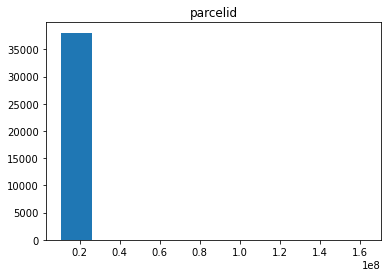

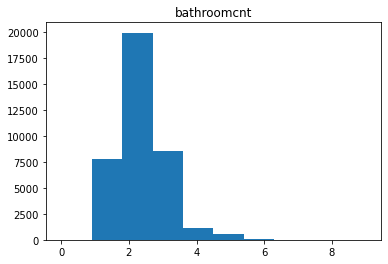

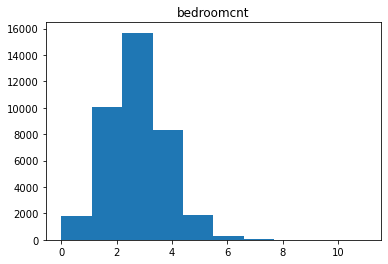

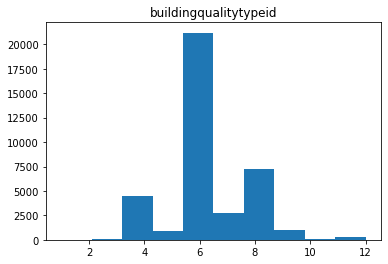

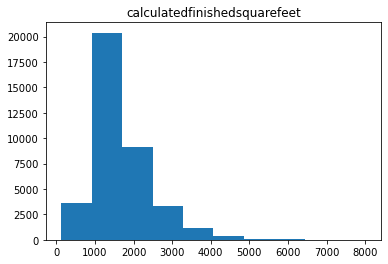

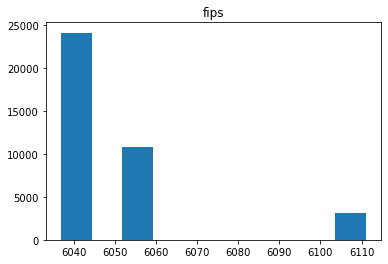

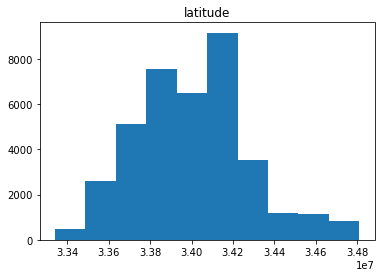

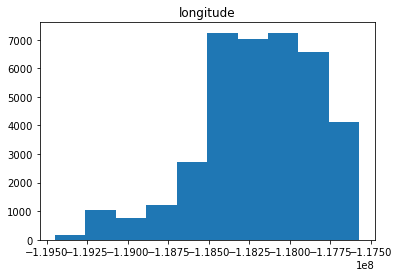

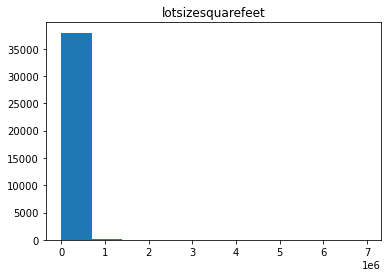

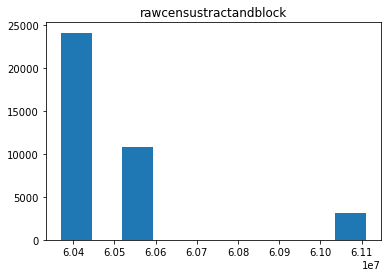

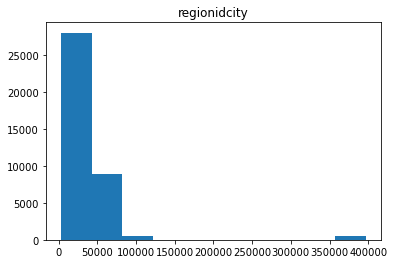

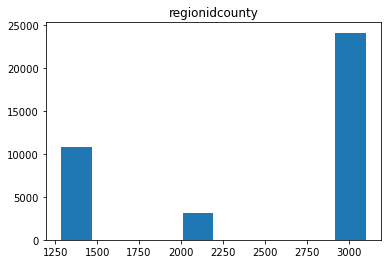

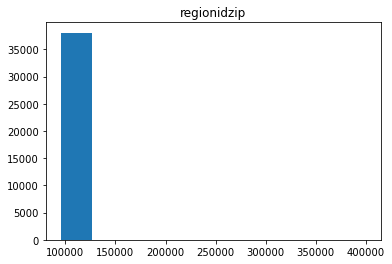

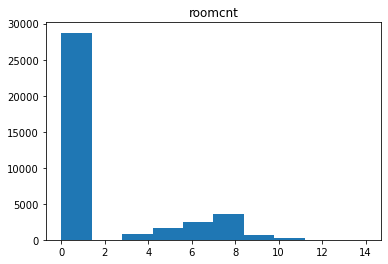

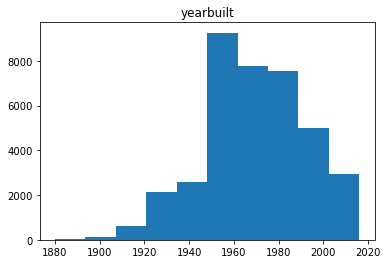

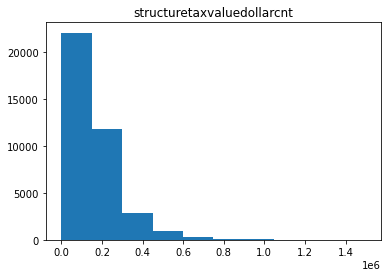

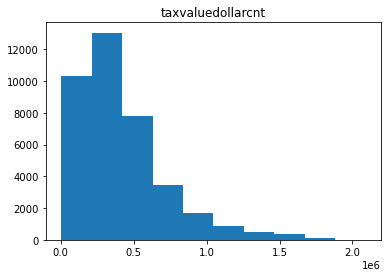

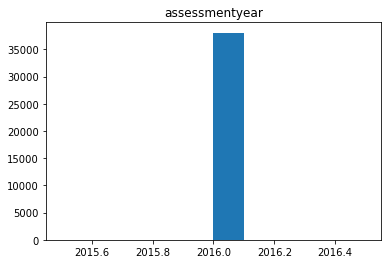

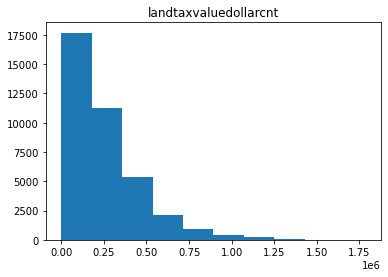

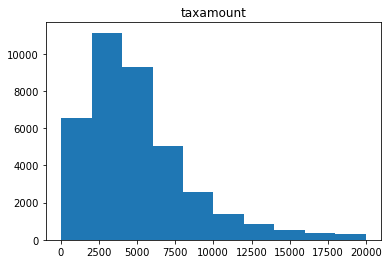

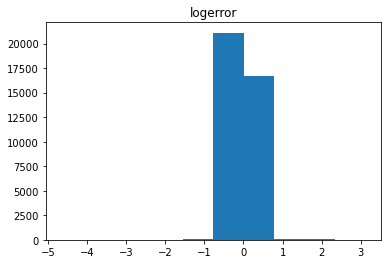

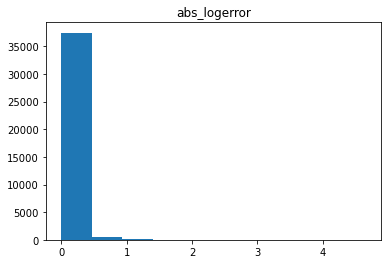

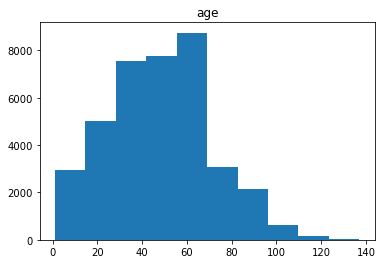

In [9]:
# Univariate distribution
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

# Takeaways
- Mostly normal distribution among features

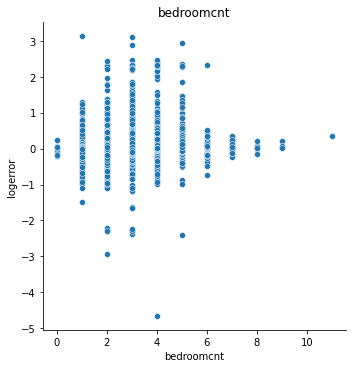

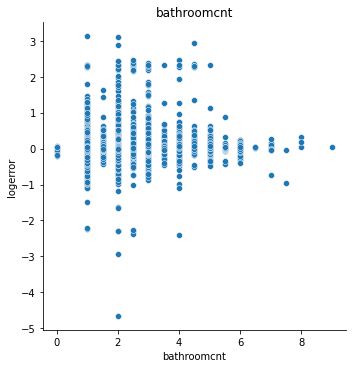

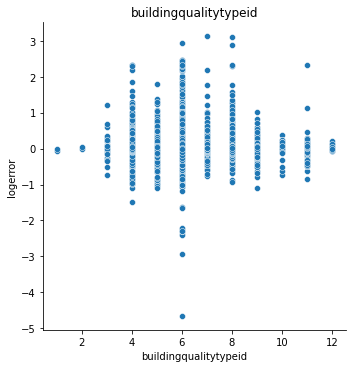

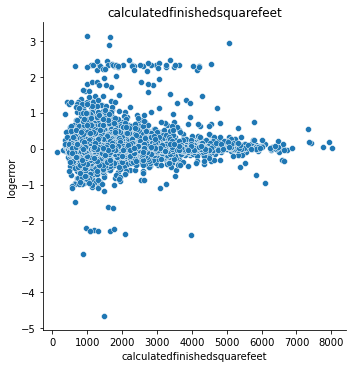

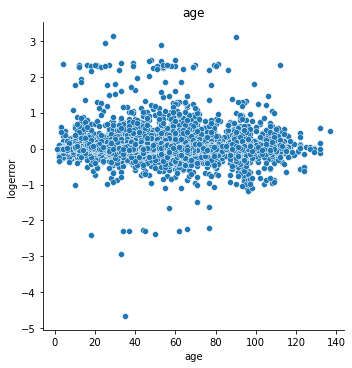

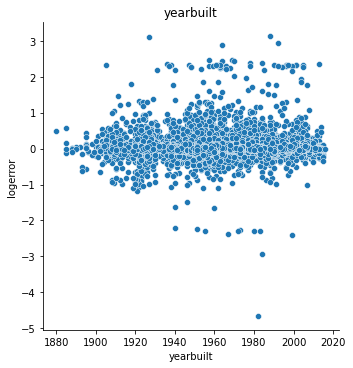

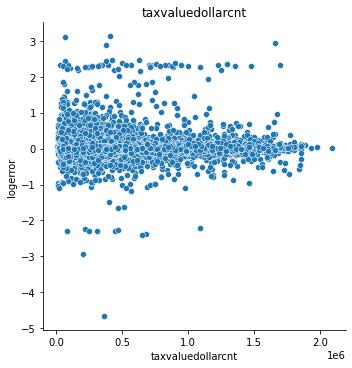

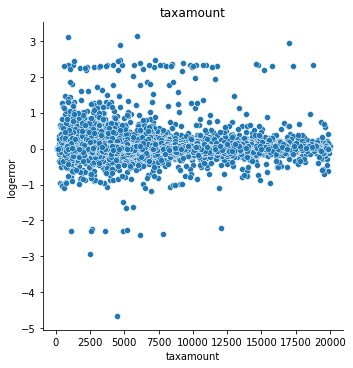

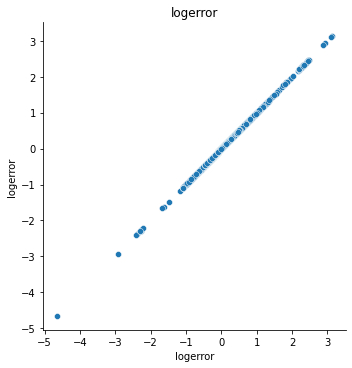

In [10]:
# Bivariate and Multivariate

exp_columns = ['bedroomcnt', 'bathroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'age', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'logerror']

for col in train[exp_columns]:
    sns.relplot(x=train[col], y=train.logerror)
    plt.title(col)
    plt.show()

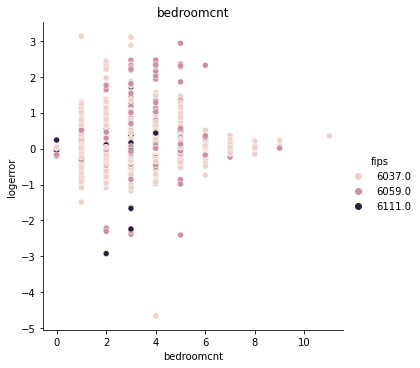

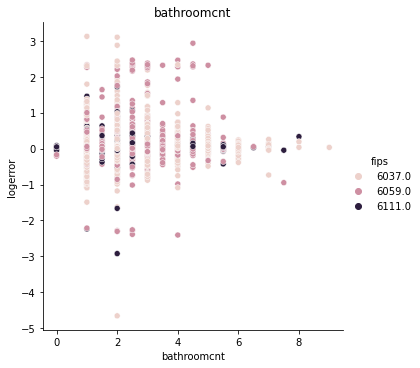

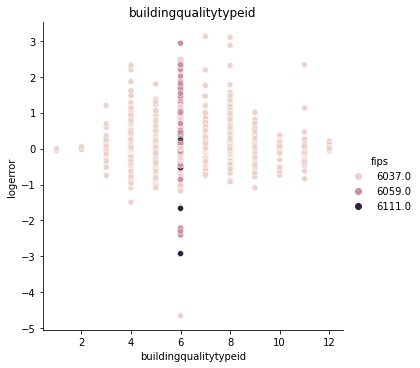

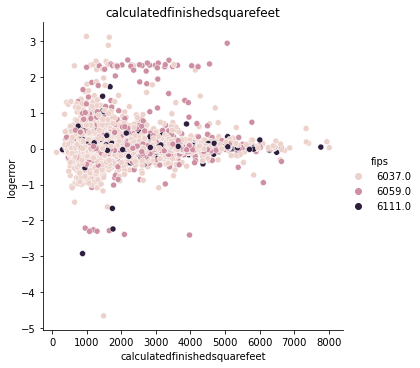

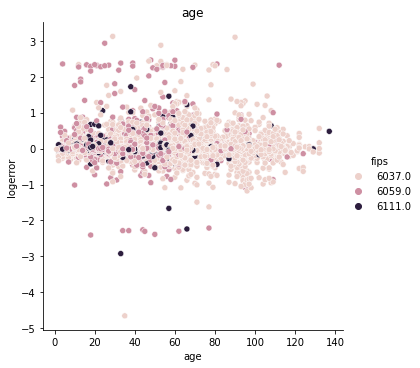

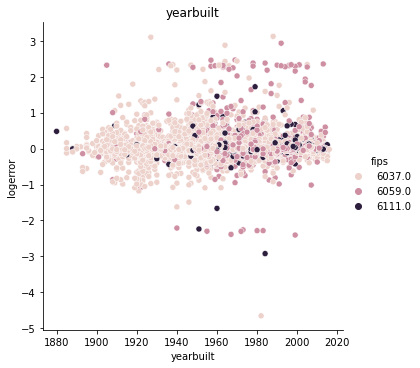

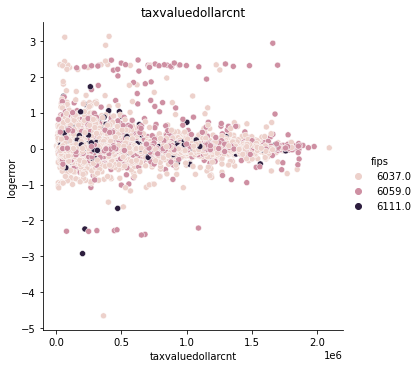

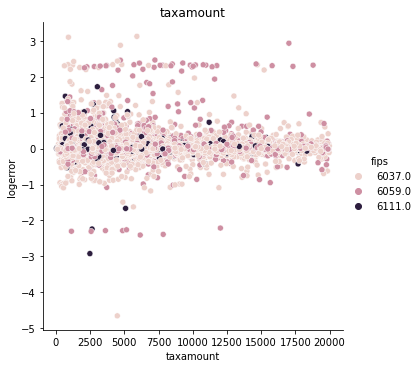

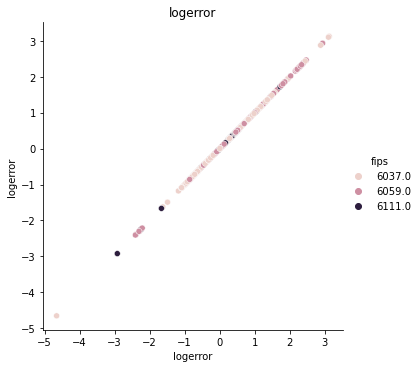

In [11]:
for col in train[exp_columns]:
    sns.relplot(x=train[col], y=train.logerror, hue=train.fips)
    plt.title(col)
    plt.show()

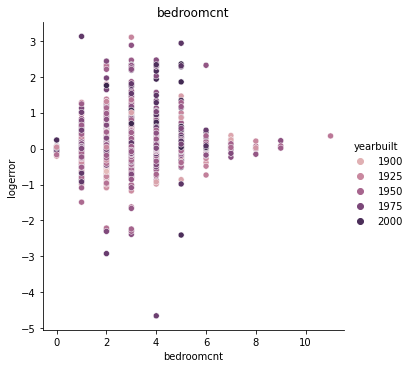

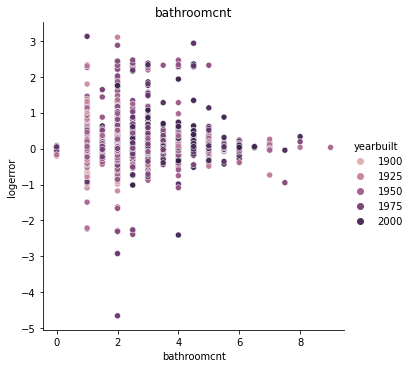

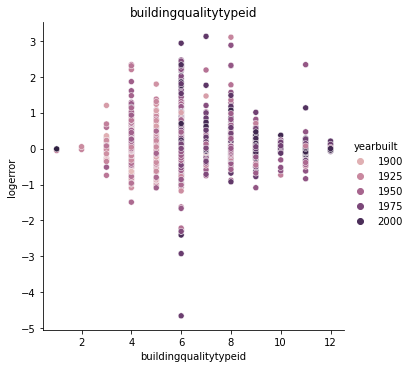

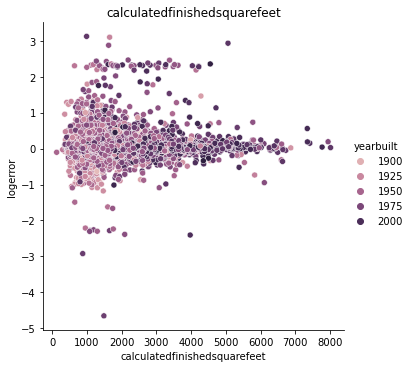

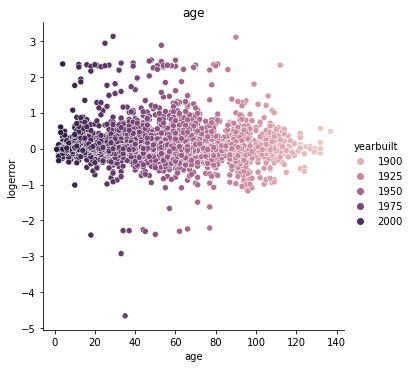

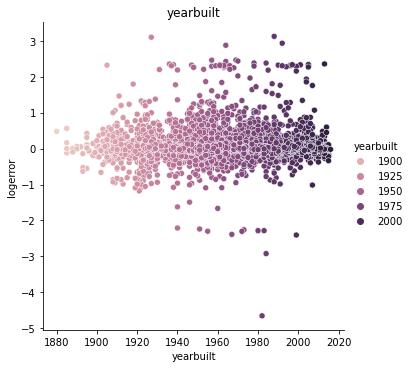

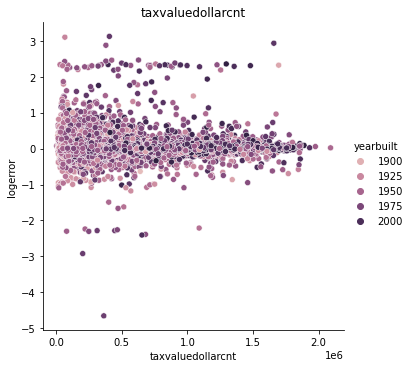

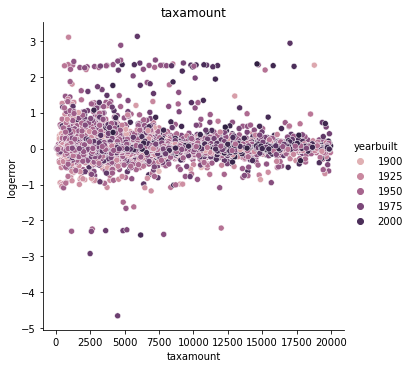

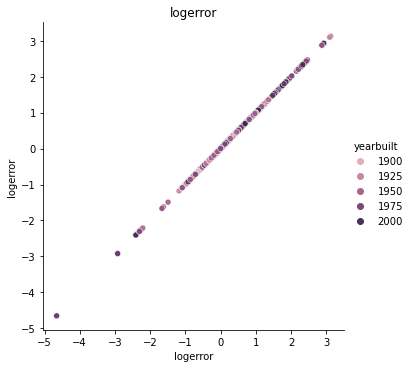

In [12]:
for col in train[exp_columns]:
    sns.relplot(x=train[col], y=train.logerror, hue=train.yearbuilt)
    plt.title(col)
    plt.show()

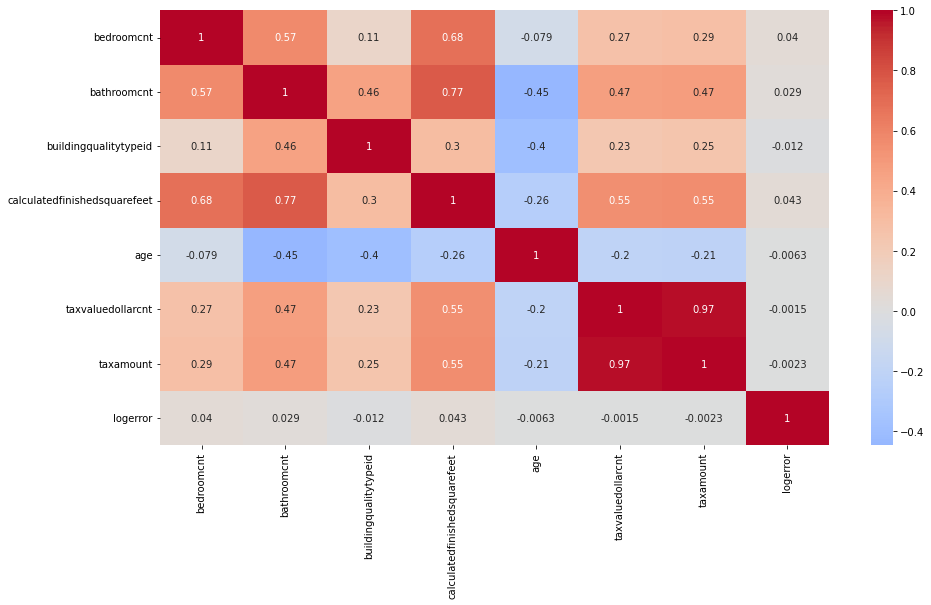

In [13]:
# Heatmap
plt.figure(figsize = (15,8))
sns.heatmap(train[exp_columns].corr(), cmap='coolwarm', center=0, annot=True)
plt.show()

# Takaways
- Newer homes tend to have higher logerror than older homes
- Higher taxamounts seem to have lower rates of logerror
- Might be worth breaking up homes by age
- LA county (fips 6037) was the only county to track buildingqualitytypeid
- Refrencing the heatmap, calulatedfinishedsquarefeet was the feature that showed the most impact on log error
---------
## Questions to explore and verify:
- Is there a relationship between logerror and age?
- Does the county(fips) influence the logerror?
- Does size of the property infuence the logerror?
- Can taxamount or taxvaluedollarcnt be used to calculate logerror?
----
### Question 1 
#### Is there a relationship between logerror and age?

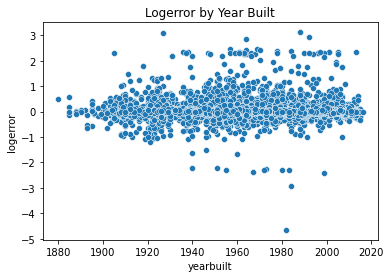

In [14]:
sns.scatterplot(data=train, y='logerror', x='yearbuilt')
plt.title('Logerror by Year Built')
plt.show()

In [15]:
stats.ttest_ind(train.yearbuilt, train.logerror,
                equal_var=True)

Ttest_indResult(statistic=16819.059485896098, pvalue=0.0)

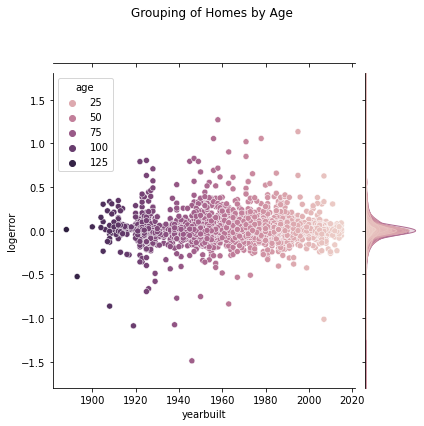

In [16]:
# logerror seems to be better before the 1950's

sample = train.sample(5000)

sns.jointplot('yearbuilt', 'logerror', data=sample, kind='scatter', hue='age', ylim=(-1.8, 1.8))
plt.suptitle('Grouping of Homes by Age')

plt.show()


In [17]:
# H0: Homes built before 1950 have no difference in logerror than homes built past 1950
# Ha: Homes built before 1950 have significant differences in logerror than homes built past 1950

stats.levene(train[train.yearbuilt <= 1950].logerror, 
             train[train.yearbuilt > 1950].logerror
            )

LeveneResult(statistic=313.67364588868776, pvalue=6.604776915086508e-70)

In [18]:
# Can assume Equal Varience
stats.ttest_ind(train[train.yearbuilt <= 1950].logerror,
                train[train.yearbuilt >1950].logerror,
                equal_var=True)

Ttest_indResult(statistic=-2.3778230931149356, pvalue=0.01742008660265203)

### The T-Test confirms we can reject the null hypothesis
- Alternative Hypothesis(Ha): Homes built before 1950 have significant differences in logerror than homes built past 1950
-------
# Question 2
- Does the county(fips) influence the logerror?

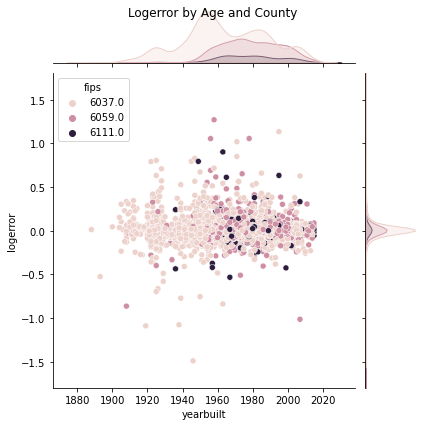

In [19]:
# Lets compare fips on our last graph
sns.jointplot('yearbuilt', 'logerror', data=sample, kind='scatter', hue='fips', ylim=(-1.8, 1.8))
plt.suptitle('Logerror by Age and County')

plt.show()

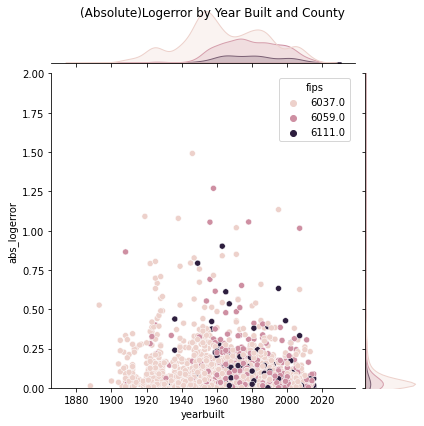

In [20]:
# different perspective
sns.jointplot('yearbuilt', 'abs_logerror', data=sample, hue='fips', kind='scatter', ylim=(0,2))

plt.suptitle('(Absolute)Logerror by Year Built and County')
plt.show()


In [21]:
# confirm with stats

# H0: LA County propeties has no significant impact on logerror than Orange and Ventura Counties
# Ha: LA County propeties does have a significant impact on logerror than Orange and Ventura Counties

stats.levene(train[train.fips == 6037].logerror, 
             train[train.fips != 6037].logerror
            )

LeveneResult(statistic=35.71270627924118, pvalue=2.306969287718477e-09)

In [22]:
# Can assume Equal Variance
# T-test
stats.ttest_ind(train[train.fips == 6037].logerror,
                train[train.fips != 6037].logerror,
                equal_var=True)

Ttest_indResult(statistic=-3.2780584817626086, pvalue=0.001046174044004433)

### The T-Test confirms we can reject the null hypothesis¶

   - Alternative Hypothesis(Ha): Properties in LA County have significant differences in logerror vs properties in other counties.
------
# Question 3
   - Does size of the property infuence the logerror?

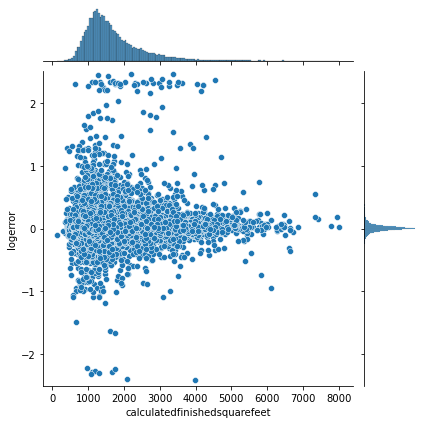

In [23]:
# I'm going to look particularly at calulatedfinishedsquarefeet
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=train, ylim=(-2.5, 2.5))
plt.show()


## Takeaways
- Smaller homes definitely have a higher log error
- As home get larger in square feet the log error decreases, clearly indicating some kind of correlation(as forecasted by the heatmap earlier)

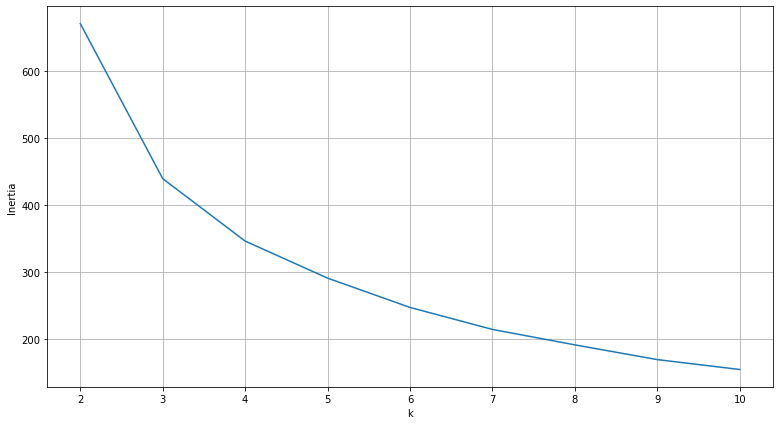

In [24]:
cols = ['calculatedfinishedsquarefeet', 'taxamount']
X = x_train_scaled[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [25]:
# I'll go with a k value of 3 for my cluster

kmeans = KMeans(n_clusters=3).fit(X)
train['cluster_area_tax'] = kmeans.predict(X)
train.cluster_area_tax = train.cluster_area_tax.astype('category')

# means of each feature by cluster
train.groupby('cluster_area_tax').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_tax,,,,,,,,,,,,,,,,,,,,,,
0,1.291052e+07,1.878343,2.700056,6.062541,1332.728348,6048.073661,3.402502e+07,-1.181889e+08,33148.271512,6.048394e+07,34251.549545,2566.692033,96574.148635,1.414563,99424.622126,2.188313e+05,2016.0,119406.717650,2772.378103,0.018619,0.068713,52.528995
1,1.315056e+07,3.227100,3.739331,7.013319,2867.927698,6051.028269,3.394416e+07,-1.182077e+08,21059.817613,6.051273e+07,31637.767600,2393.859473,96603.845338,1.581408,399549.217994,1.089752e+06,2016.0,690202.632781,13065.869774,0.027741,0.081172,40.209024
2,1.312848e+07,2.433030,3.228180,6.529029,1892.292129,6051.096688,3.399036e+07,-1.181952e+08,19963.230552,6.051368e+07,32684.623346,2423.485275,96599.797675,1.899946,199756.521839,5.389435e+05,2016.0,339186.970244,6535.169822,0.013772,0.057730,43.669165


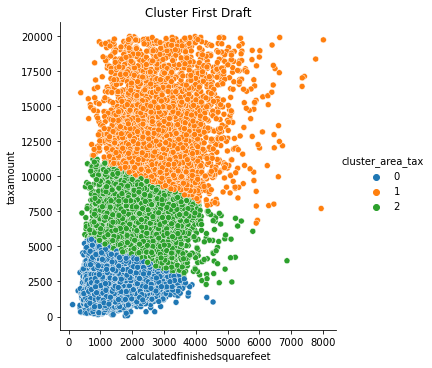

In [26]:
# Visualize clusters
sns.relplot(data=train, y='taxamount', x='calculatedfinishedsquarefeet', hue='cluster_area_tax')
plt.title('Cluster First Draft')

plt.show()

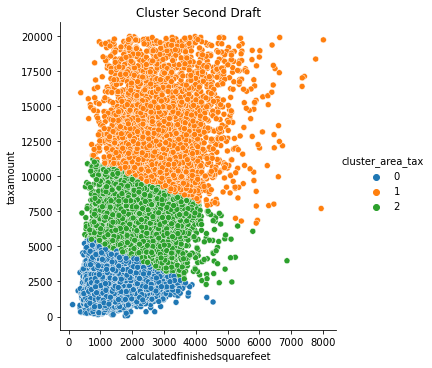

In [27]:
kmeans = KMeans(n_clusters=3).fit(X)
train['cluster_area_tax'] = kmeans.predict(X)
train.cluster_area_tax = train.cluster_area_tax.astype('category')

# visualize
sns.relplot(data=train, y='taxamount', x='calculatedfinishedsquarefeet', hue='cluster_area_tax')
plt.title('Cluster Second Draft')

plt.show()

In [28]:
train.groupby('cluster_area_tax').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_tax,,,,,,,,,,,,,,,,,,,,,,
0,1.290968e+07,1.873969,2.695679,6.058135,1329.344926,6048.043305,3.402459e+07,-1.181883e+08,33195.799062,6.048364e+07,34240.127310,2566.454610,96573.877097,1.410973,98897.138112,2.173451e+05,2016.0,118447.947693,2754.626730,0.018569,0.068778,52.591206
1,1.314626e+07,3.217881,3.736424,7.006358,2857.100927,6050.981457,3.394393e+07,-1.182071e+08,20988.476556,6.051228e+07,31664.220132,2394.323179,96601.752848,1.584901,396435.255099,1.082583e+06,2016.0,686148.073113,12980.209166,0.027555,0.081099,40.236291
2,1.312745e+07,2.428138,3.223967,6.527190,1884.876981,6051.111490,3.399199e+07,-1.181961e+08,20107.592491,6.051383e+07,32727.675161,2426.207433,96600.397345,1.899355,198454.978688,5.343147e+05,2016.0,335859.701782,6481.201024,0.013880,0.057649,43.726735


## Takeaways
- There seems to be little change to the cluster after refitting
- Cluster 1 has the lowest logerror and abs_logerror, while the mean for other feature was not as useful
--------
# Continued Cluster Exploration 
- I know from my earlier exploration that age was an indicator
- I want to check with calculatedfinishedsquarefeet and taxamount as well, and then perhaps seperately

In [29]:
# features to make cluster with
cols = ['calculatedfinishedsquarefeet', 'taxamount', 'age']
X = x_train_scaled[cols]

# make it
kmeans = KMeans(n_clusters=3).fit(X)
train['cluster_area_tax_age'] = kmeans.predict(X)
train.cluster_area_tax_age = train.cluster_area_tax_age.astype('category')

# Visualize clusters
train.groupby('cluster_area_tax_age').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_tax_age,,,,,,,,,,,,,,,,,,,,,,
0,1.341184e+07,2.572214,2.967769,6.801917,1870.743052,6054.102419,3.400912e+07,-1.181622e+08,37604.852226,6.054385e+07,30688.883814,2299.062597,96716.919583,1.444802,222979.728062,481542.569480,2016.0,258562.841418,5874.102058,0.017381,0.053393,26.275476
1,1.212399e+07,1.638593,2.688699,5.392537,1446.608316,6039.290832,3.402504e+07,-1.182533e+08,8602.900426,6.039630e+07,44239.358635,2996.243070,96228.739019,0.318124,115944.831557,389307.544136,2016.0,273362.712580,4839.064825,0.012193,0.101582,88.313220
2,1.288971e+07,2.021478,3.071276,6.132402,1560.755384,6047.954240,3.399678e+07,-1.182038e+08,23558.951043,6.048251e+07,33042.191173,2546.360307,96565.473419,2.066846,122853.119448,359355.452277,2016.0,236502.332829,4407.347490,0.019717,0.067941,56.965231


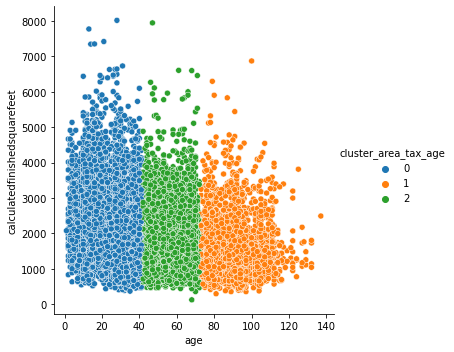

In [30]:
sns.relplot(data=train, y='calculatedfinishedsquarefeet', x='age', hue='cluster_area_tax_age')
plt.show()

In [31]:
# Not great results.  Need to narrow my search
# features to make cluster with
cols = ['calculatedfinishedsquarefeet', 'age']
X = x_train_scaled[cols]

# make it
kmeans = KMeans(n_clusters=3).fit(X)
train['cluster_area_age'] = kmeans.predict(X)
train.cluster_area_age = train.cluster_area_age.astype('category')

# Visualize clusters
train.groupby('cluster_area_age').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_age,,,,,,,,,,,,,,,,,,,,,,
0,1.288971e+07,2.021478,3.071276,6.132402,1560.755384,6047.954240,3.399678e+07,-1.182038e+08,23558.951043,6.048251e+07,33042.191173,2546.360307,96565.473419,2.066846,122853.119448,359355.452277,2016.0,236502.332829,4407.347490,0.019717,0.067941,56.965231
1,1.341184e+07,2.572214,2.967769,6.801917,1870.743052,6054.102419,3.400912e+07,-1.181622e+08,37604.852226,6.054385e+07,30688.883814,2299.062597,96716.919583,1.444802,222979.728062,481542.569480,2016.0,258562.841418,5874.102058,0.017381,0.053393,26.275476
2,1.212399e+07,1.638593,2.688699,5.392537,1446.608316,6039.290832,3.402504e+07,-1.182533e+08,8602.900426,6.039630e+07,44239.358635,2996.243070,96228.739019,0.318124,115944.831557,389307.544136,2016.0,273362.712580,4839.064825,0.012193,0.101582,88.313220


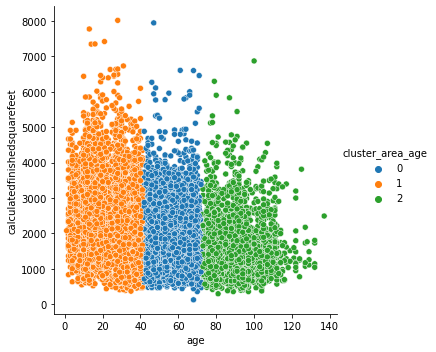

In [32]:
# Visualize
# Refinement didn't seem to change the cluster 
sns.relplot(data=train, y='calculatedfinishedsquarefeet', x='age', hue='cluster_area_age')
plt.show()


## Takeaways
- This clustering seems to just seperate homes by age into 3 groups(0-40, 40-75, 75 and up)
- While the metrics for each cluster do have some distinct differences, most of the older homes will also only be in LA County, per our previous data

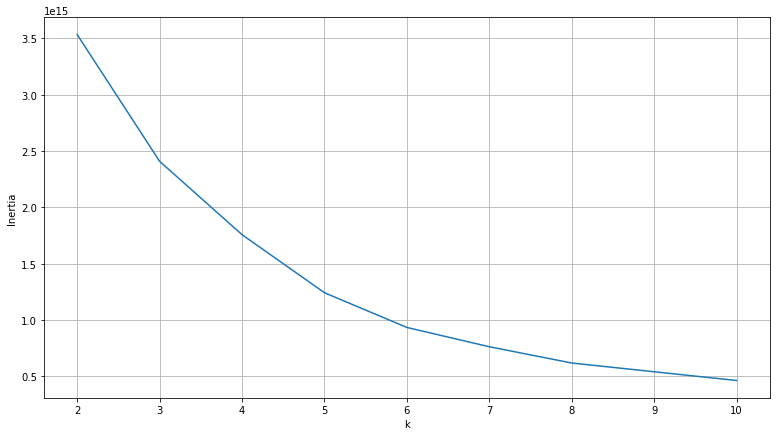

In [33]:
cols = ['latitude', 'longitude', 'age']
X = x_train_scaled[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

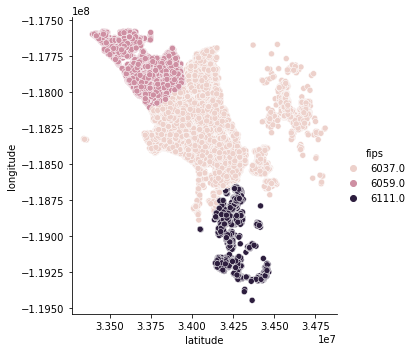

In [34]:
# a quick reference to county by geographical location
sns.relplot(data=train, x='latitude', y='longitude', hue='fips')
plt.show()

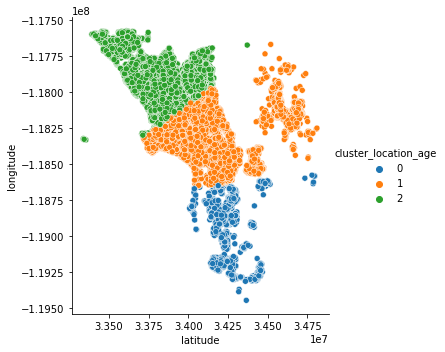

In [35]:
# Put together the cluster
cols = ['latitude', 'longitude', 'age']
X = x_train_scaled[cols]

# make it
kmeans = KMeans(n_clusters=3).fit(X)
train['cluster_location_age'] = kmeans.predict(X)
train.cluster_location_age = train.cluster_location_age.astype('category')

# Visualize clusters
sns.relplot(data=train, x='latitude', y='longitude', hue='cluster_location_age')
plt.show()

In [36]:
# metrics
train.groupby('cluster_location_age').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_location_age,,,,,,,,,,,,,,,,,,,,,,
0,1.648559e+07,2.400194,3.318547,6.194067,1922.446632,6102.157749,3.424462e+07,-1.189533e+08,19050.151927,6.102242e+07,28975.218741,2185.269476,96848.847519,5.722761,211719.811478,449849.895481,2016.0,238130.084003,5319.613285,0.018638,0.054859,37.339895
1,1.158328e+07,2.156904,2.867339,6.609630,1611.503580,6037.000000,3.415401e+07,-1.183266e+08,40949.532672,6.037422e+07,35325.955629,3101.000000,96389.035124,0.000000,160022.651801,401023.612730,2016.0,241000.960929,5081.083232,0.013303,0.073856,53.673733
2,1.377038e+07,2.200694,3.030738,6.027748,1685.044193,6051.166726,3.379595e+07,-1.178871e+08,14947.068652,6.051376e+07,32449.997967,1932.245066,96737.830224,2.401866,155394.082287,417618.234362,2016.0,262224.152075,4980.448419,0.022471,0.060401,44.954132


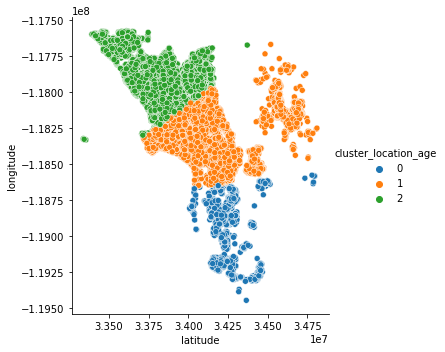

In [37]:
# Rinse and Repeat (cluster again)
train['cluster_location_age'] = kmeans.predict(X)
train.cluster_location_age = train.cluster_location_age.astype('category')

# Visualize clusters
sns.relplot(data=train, x='latitude', y='longitude', hue='cluster_location_age')
plt.show()

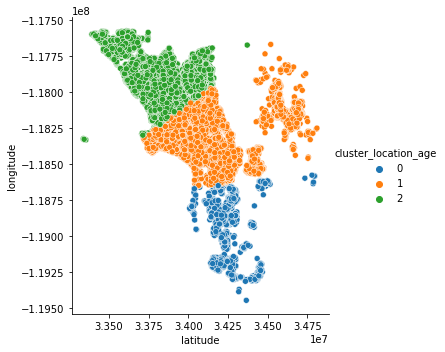

In [38]:
# Rinse and Repeat (cluster again)
train['cluster_location_age'] = kmeans.predict(X)
train.cluster_location_age = train.cluster_location_age.astype('category')

# Visualize clusters
sns.relplot(data=train, x='latitude', y='longitude', hue='cluster_location_age')
plt.show()

In [39]:
# Check any changes to metrics
train.groupby('cluster_location_age').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_location_age,,,,,,,,,,,,,,,,,,,,,,
0,1.648559e+07,2.400194,3.318547,6.194067,1922.446632,6102.157749,3.424462e+07,-1.189533e+08,19050.151927,6.102242e+07,28975.218741,2185.269476,96848.847519,5.722761,211719.811478,449849.895481,2016.0,238130.084003,5319.613285,0.018638,0.054859,37.339895
1,1.158328e+07,2.156904,2.867339,6.609630,1611.503580,6037.000000,3.415401e+07,-1.183266e+08,40949.532672,6.037422e+07,35325.955629,3101.000000,96389.035124,0.000000,160022.651801,401023.612730,2016.0,241000.960929,5081.083232,0.013303,0.073856,53.673733
2,1.377038e+07,2.200694,3.030738,6.027748,1685.044193,6051.166726,3.379595e+07,-1.178871e+08,14947.068652,6.051376e+07,32449.997967,1932.245066,96737.830224,2.401866,155394.082287,417618.234362,2016.0,262224.152075,4980.448419,0.022471,0.060401,44.954132


## Takeaways
- Cluster 3 seems to consist of only LA County(fips 6037), as well as older homes and a tendincy for more negative logerrors.
- Doesnt divide the data too much differently than if we grouped by fips. 
------
### Compare the clusters and see which would be best (if any) to use as a feature to model with

In [40]:
# calculatedfinishedsquarefeet and age
train.groupby('cluster_area_age').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_age,,,,,,,,,,,,,,,,,,,,,,
0,1.288971e+07,2.021478,3.071276,6.132402,1560.755384,6047.954240,3.399678e+07,-1.182038e+08,23558.951043,6.048251e+07,33042.191173,2546.360307,96565.473419,2.066846,122853.119448,359355.452277,2016.0,236502.332829,4407.347490,0.019717,0.067941,56.965231
1,1.341184e+07,2.572214,2.967769,6.801917,1870.743052,6054.102419,3.400912e+07,-1.181622e+08,37604.852226,6.054385e+07,30688.883814,2299.062597,96716.919583,1.444802,222979.728062,481542.569480,2016.0,258562.841418,5874.102058,0.017381,0.053393,26.275476
2,1.212399e+07,1.638593,2.688699,5.392537,1446.608316,6039.290832,3.402504e+07,-1.182533e+08,8602.900426,6.039630e+07,44239.358635,2996.243070,96228.739019,0.318124,115944.831557,389307.544136,2016.0,273362.712580,4839.064825,0.012193,0.101582,88.313220


In [41]:
# latitude, longitude, age
train.groupby('cluster_location_age').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_location_age,,,,,,,,,,,,,,,,,,,,,,
0,1.648559e+07,2.400194,3.318547,6.194067,1922.446632,6102.157749,3.424462e+07,-1.189533e+08,19050.151927,6.102242e+07,28975.218741,2185.269476,96848.847519,5.722761,211719.811478,449849.895481,2016.0,238130.084003,5319.613285,0.018638,0.054859,37.339895
1,1.158328e+07,2.156904,2.867339,6.609630,1611.503580,6037.000000,3.415401e+07,-1.183266e+08,40949.532672,6.037422e+07,35325.955629,3101.000000,96389.035124,0.000000,160022.651801,401023.612730,2016.0,241000.960929,5081.083232,0.013303,0.073856,53.673733
2,1.377038e+07,2.200694,3.030738,6.027748,1685.044193,6051.166726,3.379595e+07,-1.178871e+08,14947.068652,6.051376e+07,32449.997967,1932.245066,96737.830224,2.401866,155394.082287,417618.234362,2016.0,262224.152075,4980.448419,0.022471,0.060401,44.954132


In [42]:
# calculatedfinishedsquarefeet and taxamount
train.groupby('cluster_area_tax').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_tax,,,,,,,,,,,,,,,,,,,,,,
0,1.290968e+07,1.873969,2.695679,6.058135,1329.344926,6048.043305,3.402459e+07,-1.181883e+08,33195.799062,6.048364e+07,34240.127310,2566.454610,96573.877097,1.410973,98897.138112,2.173451e+05,2016.0,118447.947693,2754.626730,0.018569,0.068778,52.591206
1,1.314626e+07,3.217881,3.736424,7.006358,2857.100927,6050.981457,3.394393e+07,-1.182071e+08,20988.476556,6.051228e+07,31664.220132,2394.323179,96601.752848,1.584901,396435.255099,1.082583e+06,2016.0,686148.073113,12980.209166,0.027555,0.081099,40.236291
2,1.312745e+07,2.428138,3.223967,6.527190,1884.876981,6051.111490,3.399199e+07,-1.181961e+08,20107.592491,6.051383e+07,32727.675161,2426.207433,96600.397345,1.899355,198454.978688,5.343147e+05,2016.0,335859.701782,6481.201024,0.013880,0.057649,43.726735


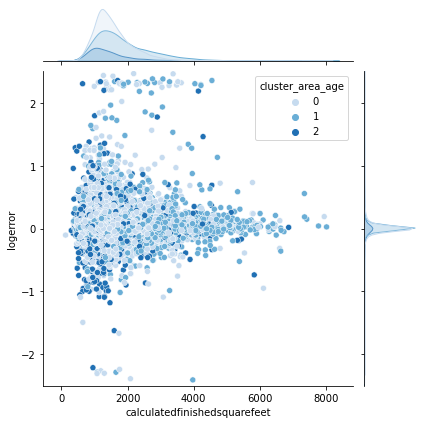

In [43]:
# calculatedfinishedsquarefeet and age
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=train, hue='cluster_area_age', palette='Blues', ylim=(-2.5, 2.5))
plt.show()

In [ ]:
# latitude, longitude, age
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=train, hue='cluster_location_age', palette='Blues', ylim=(-2.5, 2.5))
plt.show()

In [ ]:
# calculatedfinishedsquarefeet and taxamount
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=train, hue='cluster_area_tax', palette='Blues', ylim=(-2.5, 2.5))
plt.show()

## Takeaways
- Based off visuals and metrics taken on the 3 cluster groups, the cluster_area_tax group has the most relevant data that will hold the most weight for a model
- cluster_area_tax will more than likely be the only cluster group I use as a feature when modeling
---------
# Let's Build Some Models

In [ ]:
# set up cluster for validate
cols = ['calculatedfinishedsquarefeet', 'taxamount']
X = x_validate_scaled[cols]

# make it
kmeans = KMeans(n_clusters=3).fit(X)
validate['cluster_area_tax'] = kmeans.predict(X)
validate.cluster_area_tax = validate.cluster_area_tax.astype('category')

In [ ]:
# add cluster to data
dummy_df = pd.get_dummies(train['cluster_area_tax'], dummy_na=False, drop_first=True)

# append dummy df cols to the original df. 
x_train = pd.concat([x_train, dummy_df], axis=1)

# add cluster to validate data
dummy_df = pd.get_dummies(validate['cluster_area_tax'], dummy_na=False, drop_first=True)

# append dummy df cols to the original df. 
x_validate = pd.concat([x_validate, dummy_df], axis=1)


# train
predictions = pd.DataFrame()
predictions['actual'] = train.logerror
predictions['baseline'] = train.logerror.median()

# validate
validate_predictions = pd.DataFrame()
validate_predictions['actual'] = validate.logerror
validate_predictions['baseline'] = validate.logerror.median()

### Advanced Baseline

In [ ]:
# Our 'Adv. Baseline' is just a simple linear regression based off sqr_feet

x_train_bl = x_train[['age']]
x_validate_bl = x_validate[['age']]

model = sklearn.linear_model.LinearRegression()

# train
model.fit(x_train_bl, y_train)
predictions['adv_baseline'] = model.predict(x_train_bl)

# validate
validate_predictions['adv_baseline_validate'] = model.predict(x_validate_bl)

# score
model.score(x_train_bl, y_train)

In [ ]:
# The math behind our advanced baseline model
m, b = model.coef_[0], model.intercept_

print(f'Tax Value = {m:.4f} x sqr_feet + {b:.4f}')

### Multiple Regression Model

In [ ]:
# multiple regression
model = sklearn.linear_model.LinearRegression()

# train
model.fit(x_train, y_train)
predictions['multi_regression'] = model.predict(x_train)

# validate
validate_predictions['multi_regression_validate'] = model.predict(x_validate)

# score
model.score(x_train, y_train)

### Multiple Regression with RFE Model

In [ ]:
# Multiple regression with RME
model = sklearn.linear_model.LinearRegression()
rfe = sklearn.feature_selection.RFE(model, n_features_to_select=4)

# train
rfe.fit(x_train, y_train)
x_train_rfe = rfe.transform(x_train)
model.fit(x_train_rfe, y_train)
predictions['multiple_rfe'] = model.predict(x_train_rfe)

# validate
x_validate_rfe = rfe.transform(x_validate)
validate_predictions['multiple_rfe_validate'] = model.predict(x_validate_rfe)

# score
model.score(x_train_rfe, y_train)


In [ ]:
# KNN (k=2)
model = KNeighborsRegressor(n_neighbors=2)

# train
model.fit(x_train_scaled, y_train)
predictions['KNN(k=2)'] = model.predict(x_train_scaled)

# validate
validate_predictions['KNN(k=2)_validate'] = model.predict(x_validate_scaled)

# score
model.score(x_train_scaled, y_train)

In [ ]:
# # Polynomial (degree=2)
# poly = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False,  interaction_only=False)

# # train
# poly.fit(x_train)

# x_train_poly = pd.DataFrame(poly.transform(x_train),
#     columns=pd.DataFrame(poly.get_feature_names(x_train.columns)),
#     index=train.index,
#     )

# # validate
# x_validate_poly = pd.DataFrame(poly.transform(x_validate),
#     columns=pd.DataFrame(poly.get_feature_names(x_validate.columns)),
#     index=validate.index,
#     )

# # add it to our list
# model = sklearn.linear_model.LinearRegression()

# # train
# model.fit(x_train_poly, y_train)
# predictions['poly(degree=2)'] = model.predict(x_train_poly)

# # validate
# validate_predictions['poly(degree=2)_validate'] = model.predict(x_validate_poly)

# # score
# model.score(x_train_poly, y_train)

In [ ]:
predictions.head(3)

In [ ]:
validate_predictions.head(3)

In [ ]:
# Compare how these models work on the train sample
pd.concat([
    predictions.apply(lambda col: r2_score(predictions.actual, col)).rename('r2'),
    predictions.apply(lambda col: mean_squared_error(predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

In [ ]:
# Compare how these models work on the validate sample
pd.concat([
    validate_predictions.apply(lambda col: r2_score(validate_predictions.actual, col)).rename('r2'),
    validate_predictions.apply(lambda col: mean_squared_error(validate_predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

In [ ]:
# Going to use RMSE to compare our model to determine how much error the typical prediction will have. 
# With that in mind, I will go with the multiple regression model that out-performs the baseline RMSE by an average of 0.005
# This will be the only model to be used on test

# Verify Model on Unseen Data (Test)

In [ ]:
# add cluster to test data
# set up cluster for validate
cols = ['calculatedfinishedsquarefeet', 'taxamount']
X = x_test_scaled[cols]

# make it
kmeans = KMeans(n_clusters=3).fit(X)
test['cluster_area_tax'] = kmeans.predict(X)
test.cluster_area_tax = test.cluster_area_tax.astype('category')
dummy_df = pd.get_dummies(test['cluster_area_tax'], dummy_na=False, drop_first=True)

# append dummy df cols to the original df. 
x_test = pd.concat([x_test, dummy_df], axis=1)


# test predictions and baseline
test_predictions = pd.DataFrame()
test_predictions['actual'] = test.logerror
test_predictions['baseline'] = test.logerror.median()

In [ ]:
# make it
model = sklearn.linear_model.LinearRegression()

# fit it
model.fit(x_train, y_train)

# use it
predictions['multi_regression'] = model.predict(x_test)




In [ ]:
pd.concat([
    test_predictions.apply(lambda col: r2_score(test_predictions.actual, col)).rename('r2'),
    test_predictions.apply(lambda col: mean_squared_error(test_predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)